## Import Data

In [1]:
import os
dataset_path = r'C:\Users\Fathan Askar\Downloads\DatasetViskom\DatasetViskom'
file_list = os.listdir(dataset_path)
print(file_list)

['butterfly', 'cat', 'chicken', 'cow', 'dog', 'elephant', 'horse', 'sheep', 'spider', 'squirrel']


In [2]:
# %pip install --upgrade tensorflow

## Import Functions

In [3]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import random

# Import visualization libraries
import matplotlib.pyplot as plt
import cv2
import seaborn as sns

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

# System libraries
from pathlib import Path
import os.path
import requests

# Metrics
from sklearn.metrics import classification_report

sns.set_style('darkgrid')

In [4]:
#Seeding to keep the images the same for multiple runs
def seed_everything(seed=42):
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.config.threading.set_intra_op_parallelism_threads(1)
    tf.config.threading.set_inter_op_parallelism_threads(1)

seed_everything()

In [5]:
#URL of the helper function just to walk through directory
url = 'https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py'
response = requests.get(url)
with open('helper_functions.py', 'wb') as file:
    file.write(response.content)

from helper_functions import walk_through_dir

In [6]:
#Batch size used, target size of the images
BATCH_SIZE = 32
TARGET_SIZE = (224, 224)

In [7]:
#Walking thorugh dataset to see the amount of images
dataset = dataset_path
walk_through_dir(dataset)

There are 10 directories and 0 images in 'C:\Users\Fathan Askar\Downloads\DatasetViskom\DatasetViskom'.
There are 0 directories and 2112 images in 'C:\Users\Fathan Askar\Downloads\DatasetViskom\DatasetViskom\butterfly'.
There are 0 directories and 1668 images in 'C:\Users\Fathan Askar\Downloads\DatasetViskom\DatasetViskom\cat'.
There are 0 directories and 3098 images in 'C:\Users\Fathan Askar\Downloads\DatasetViskom\DatasetViskom\chicken'.
There are 0 directories and 1866 images in 'C:\Users\Fathan Askar\Downloads\DatasetViskom\DatasetViskom\cow'.
There are 0 directories and 4863 images in 'C:\Users\Fathan Askar\Downloads\DatasetViskom\DatasetViskom\dog'.
There are 0 directories and 1446 images in 'C:\Users\Fathan Askar\Downloads\DatasetViskom\DatasetViskom\elephant'.
There are 0 directories and 2623 images in 'C:\Users\Fathan Askar\Downloads\DatasetViskom\DatasetViskom\horse'.
There are 0 directories and 1820 images in 'C:\Users\Fathan Askar\Downloads\DatasetViskom\DatasetViskom\sheep

In [8]:
#Making a df
def convert_path_to_df(dataset):
    image_dir = Path(dataset)
    filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.jpeg')) + list(image_dir.glob(r'**/*.PNG'))
    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))
    filepaths = pd.Series(filepaths, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')
    image_df = pd.concat([filepaths, labels], axis=1)
    return image_df

image_df = convert_path_to_df(dataset)

C:\Users\Fathan Askar\AppData\Local\Temp\ipykernel_2180\2290020164.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, hue=None, alpha=0.8, palette='pastel', ax=axes)


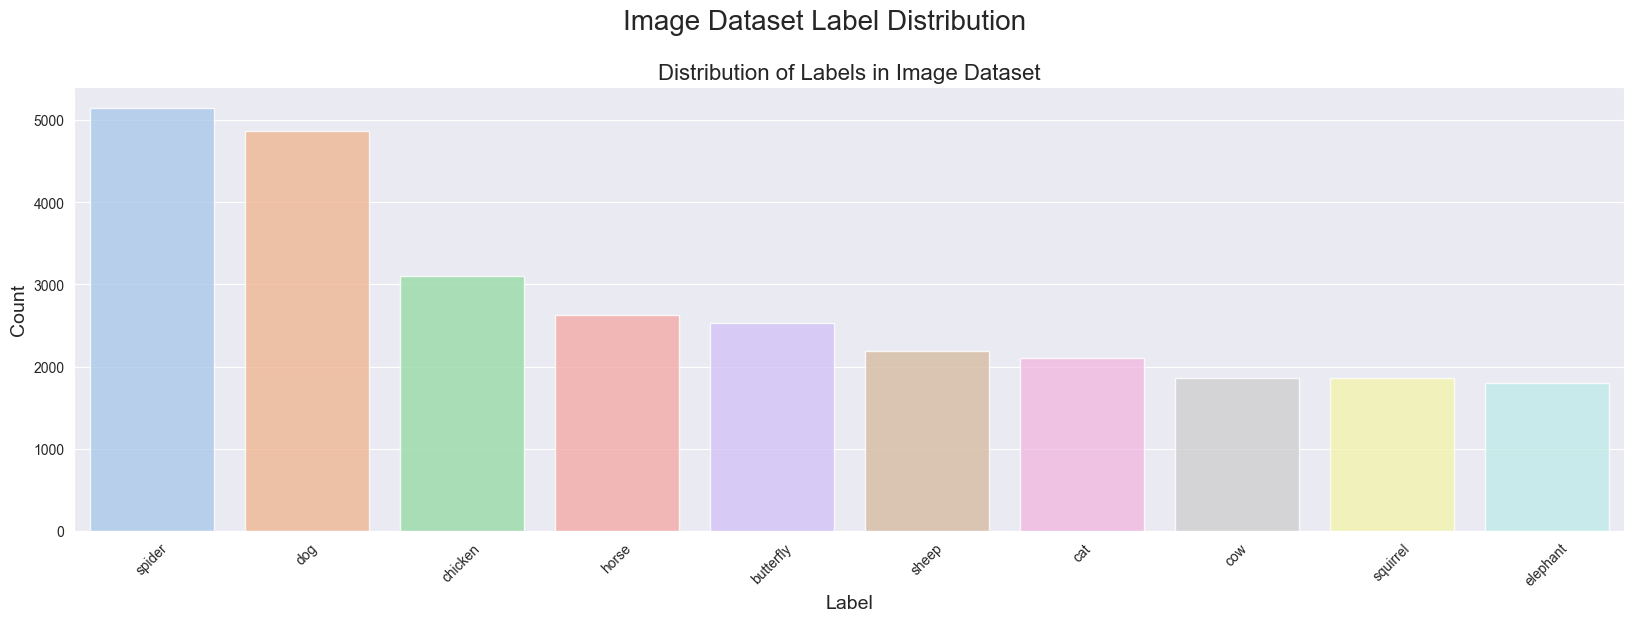

In [9]:
#Get the value counts for each label
label_counts = image_df['Label'].value_counts()

#Create the figure and axes
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 6))

#Plot the bar chart
sns.barplot(x=label_counts.index, y=label_counts.values, hue=None, alpha=0.8, palette='pastel', ax=axes)
axes.set_title('Distribution of Labels in Image Dataset', fontsize=16)
axes.set_xlabel('Label', fontsize=14)
axes.set_ylabel('Count', fontsize=14)

#Set x-ticks and labels
axes.set_xticks(range(len(label_counts.index)))
axes.set_xticklabels(label_counts.index, rotation=45)
fig.suptitle('Image Dataset Label Distribution', fontsize=20)
fig.subplots_adjust(top=0.85)

plt.show()


C:\Users\Fathan Askar\AppData\Local\Temp\ipykernel_2180\713277076.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts_limited.index, y=label_counts_limited.values, hue=None, alpha=0.8, palette='pastel', ax=axes)


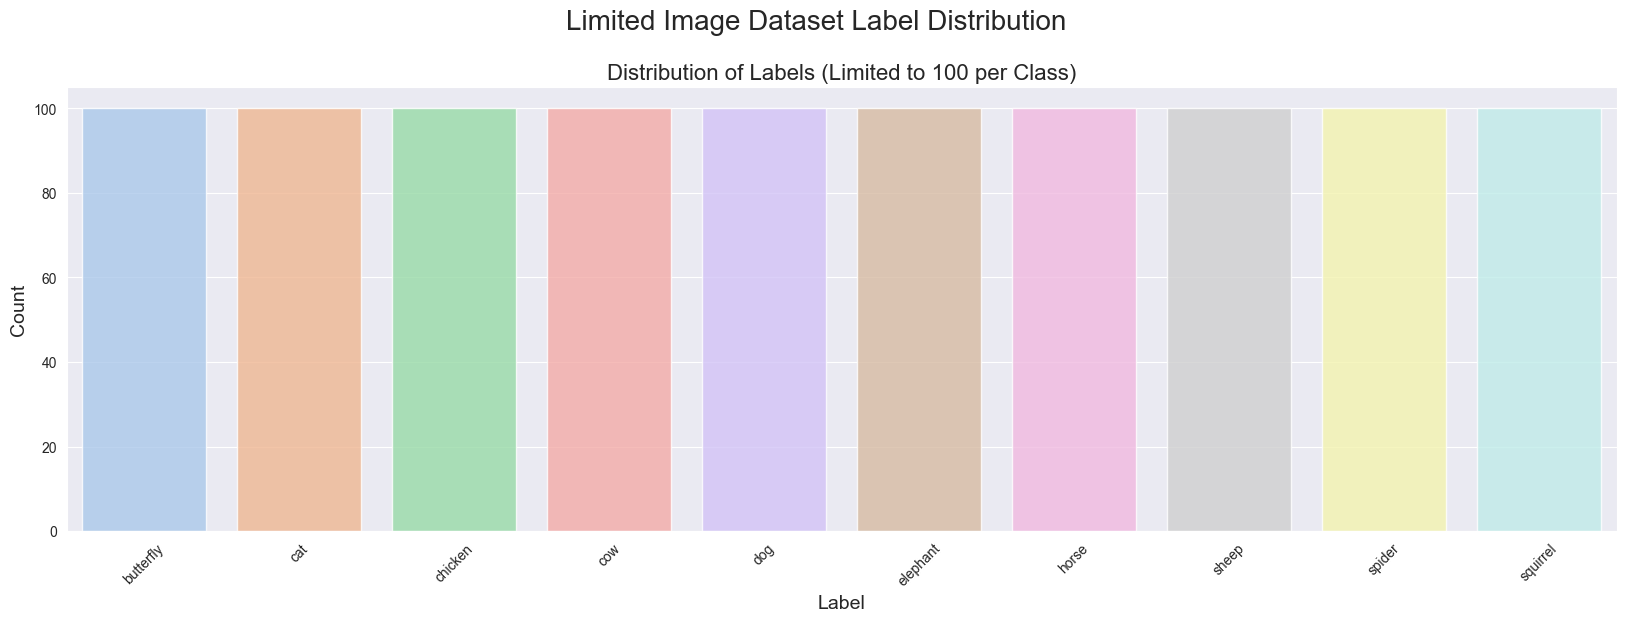

In [10]:
#Limit the number of images to 100 per class
def limit_images_per_class(image_df, num_images=100):
    image_df_limited = image_df.groupby('Label').apply(lambda x: x.sample(min(len(x), num_images), random_state=42)).reset_index(drop=True)
    return image_df_limited

#Create a df for the limited images per class
image_df_limited = limit_images_per_class(image_df, num_images=100)
label_counts_limited = image_df_limited['Label'].value_counts()

# Plot the updated distribution
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 6))
sns.barplot(x=label_counts_limited.index, y=label_counts_limited.values, hue=None, alpha=0.8, palette='pastel', ax=axes)
axes.set_title('Distribution of Labels (Limited to 100 per Class)', fontsize=16)
axes.set_xlabel('Label', fontsize=14)
axes.set_ylabel('Count', fontsize=14)
axes.set_xticks(range(len(label_counts_limited.index)))
axes.set_xticklabels(label_counts_limited.index, rotation=45)
fig.suptitle('Limited Image Dataset Label Distribution', fontsize=20)
fig.subplots_adjust(top=0.85)

plt.show()


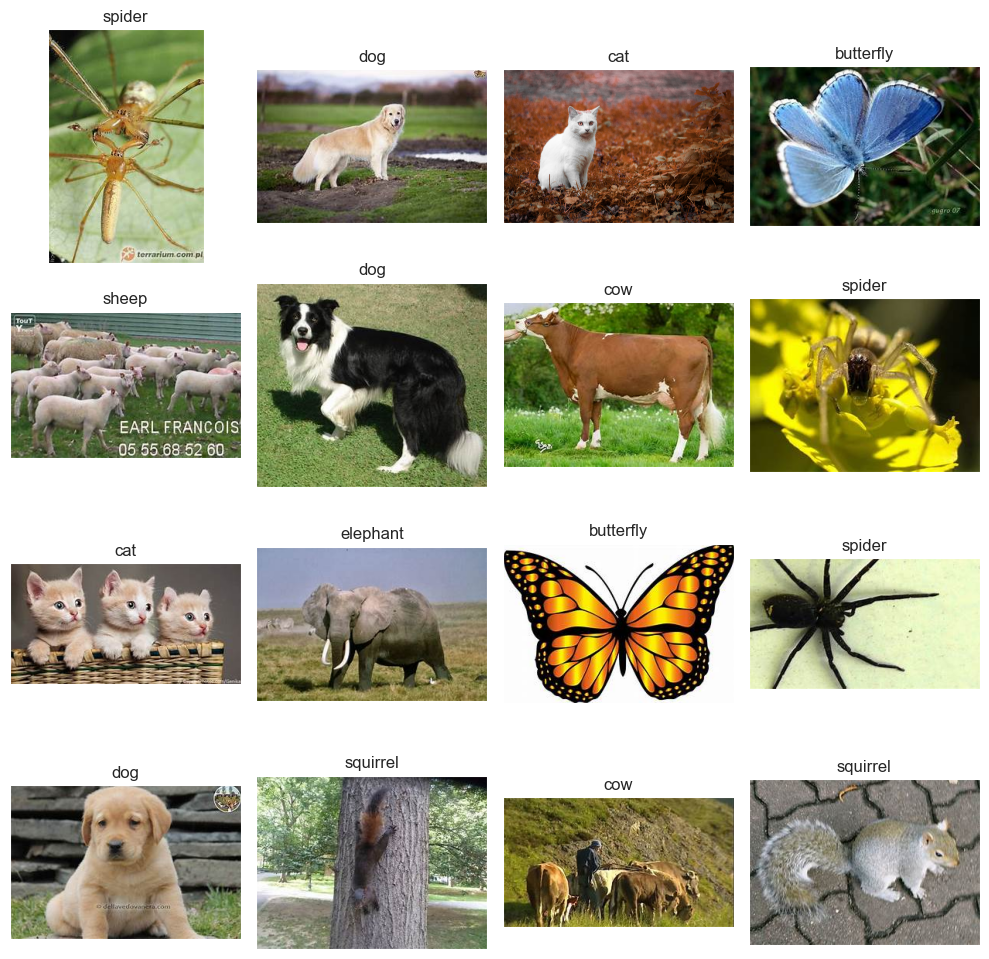

In [11]:
#Display 16 picture of the dataset with their labels
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

## Preprocessing

In [12]:
#Preprocessing Functions

#Normalization or Standardization
def normalize_image(image):
    return image / 255.0
def standardize_image(image):
    mean = np.mean(image, axis=(0, 1, 2), keepdims=True)
    std = np.std(image, axis=(0, 1, 2), keepdims=True)
    return (image - mean) / std 

#Enhancement
def enhance_image(image):
    #Apply contrast enhancement by changing color from RGB to LAB
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    #Apply CLAHE to L channel
    clip_limit = np.var(l) / 255
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    #Combine the L Channel back to LAB
    lab = cv2.merge((cl, a, b))
    enhanced_image = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)
    #Apply Histogram Equalization YCrCB (Y is brightness, Cr&Cb are color components)
    ycrcb = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    y, cr, cb = cv2.split(ycrcb)
    y_eq = cv2.equalizeHist(y)
    ycrcb = cv2.merge((y_eq, cr, cb))
    hist_eq_image = cv2.cvtColor(ycrcb, cv2.COLOR_YCrCb2RGB)

    return (enhanced_image * 0.5 + hist_eq_image * 0.5).astype(np.uint8)


#Noise Removal
def remove_noise(image):
    #Reduce noise while preseerving edges
    bilateral_filter = cv2.bilateralFilter(image, 9, 75, 75)
    #Median Blur to the filter
    median_blur = cv2.medianBlur(bilateral_filter, 5)
    #Gaussian Blur to the median blur
    gaussian_blur = cv2.GaussianBlur(median_blur, (5, 5), 0)

    return gaussian_blur


#Geometric Transformation
def apply_geometric_transformation(image):
    #Random flip
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)  # Also try vertical flips
    
    #Random rotation
    image = tf.image.rot90(image, k=np.random.randint(1, 4))  # Rotate 90, 180, or 270 degrees

    #Random zoom and crop
    scales = list(np.arange(0.8, 1.2, 0.05))  # Zoom range from 80% to 120%
    scale = np.random.choice(scales)
    resize_shape = [int(224 * scale), int(224 * scale)]

    #Resize first to a larger size to ensure we can crop to 224x224
    image = tf.image.resize(image, resize_shape)

    #Check if the resized image is large enough for cropping
    if image.shape[0] >= 224 and image.shape[1] >= 224:
        image = tf.image.random_crop(image, size=[224, 224, 3])
    else:
        #Resize it back to 224x224 if it gets too small
        image = tf.image.resize(image, [224, 224])

    #Random brightness/contrast
    image = tf.image.random_brightness(image, max_delta=0.3)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)

    return image.numpy().astype(np.uint8)




In [13]:
#Separate dataset into train, validation and test sets manually (80% train, 10% validation, 10% test)
train_df, temp_df = train_test_split(image_df_limited, test_size=0.2, shuffle=True, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, shuffle=True, random_state=42) 


In [14]:
#Function to manually preprocess and load the data
def preprocess_images(image_paths, preprocess_function):
    processed_images = []
    for path in image_paths:
        image = cv2.imread(path) 
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
        image = cv2.resize(image, TARGET_SIZE) 
        processed_image = preprocess_function(image)
        processed_images.append(processed_image)
    return np.array(processed_images)

#Function to only resize the images (NO IMAGE PREPROCESSING JUST RESIZING TO 224x224)
def resize_images(image_paths):
    resized_images = []
    for path in image_paths:
        image = cv2.imread(path)  
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  
        image = cv2.resize(image, (224, 224)) 
        resized_images.append(image)
    return np.array(resized_images)


# Get file paths from the DataFrame
train_image_paths = train_df['Filepath'].tolist()
val_image_paths = val_df['Filepath'].tolist()
test_image_paths = test_df['Filepath'].tolist()


#No Preprocessing
train_images_resized = resize_images(train_image_paths)
val_images_resized = resize_images(val_image_paths)
test_images_resized = resize_images(test_image_paths)

#Normalization & Standardization
train_images_normalized = preprocess_images(train_image_paths, normalize_image)
val_images_normalized = preprocess_images(val_image_paths, normalize_image)
test_images_normalized = preprocess_images(test_image_paths, normalize_image)
train_images_standardized = preprocess_images(train_image_paths, standardize_image)
val_images_standardized = preprocess_images(val_image_paths, standardize_image)
test_images_standardized = preprocess_images(test_image_paths, standardize_image)

#Enhancement
train_images_enhanced = preprocess_images(train_image_paths, enhance_image)
val_images_enhanced = preprocess_images(val_image_paths, enhance_image)
test_images_enhanced = preprocess_images(test_image_paths, enhance_image)

#Noise Removal
train_images_denoised = preprocess_images(train_image_paths, remove_noise)
val_images_denoised = preprocess_images(val_image_paths, remove_noise)
test_images_denoised = preprocess_images(test_image_paths, remove_noise)

#Geometric Transformation
train_images_transformed = preprocess_images(train_image_paths, apply_geometric_transformation)
val_images_transformed = preprocess_images(val_image_paths, apply_geometric_transformation)
test_images_transformed = preprocess_images(test_image_paths, apply_geometric_transformation)


#Convert labels to one-hot encoding
train_labels = pd.get_dummies(train_df['Label']).values
val_labels = pd.get_dummies(val_df['Label']).values
test_labels = pd.get_dummies(test_df['Label']).values

class_names = train_df['Label'].unique()


### Training Model

In [15]:
#Creating a simple CNN Model
model = models.Sequential([
    layers.Input(shape=(224, 224, 3)),
    
    #Convolutional Block 1
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    #Convolutional Block 2
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    #Convolutional Block 3
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    #Global Average Pooling instead of Flattening
    layers.GlobalAveragePooling2D(),

    #Fully Connected Layer with Dropout
    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),  # L2 regularization
    layers.Dropout(0.6),  
    
    #Output Layer
    layers.Dense(train_labels.shape[1], activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 165,322 (645.79 KB)

 Trainable params: 164,874 (644.04 KB)

 Non-trainable params: 448 (1.75 KB)

### No Preprocessing

In [16]:
history_resized = model.fit(
    train_images_resized, train_labels,
    validation_data=(val_images_resized, val_labels),
    epochs=10,
    batch_size=16
)

test_loss, test_accuracy = model.evaluate(test_images_resized, test_labels)
print(f"Test accuracy on resized images: {test_accuracy * 100:.2f}%")

# Predict labels for resized test dataset and evaluate using classification report
predicted_labels_resized = model.predict(test_images_resized)
predicted_labels_resized = np.argmax(predicted_labels_resized, axis=1)
true_labels_resized = np.argmax(test_labels, axis=1)

print(classification_report(true_labels_resized, predicted_labels_resized, target_names=class_names))


Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.1133 - loss: 2.6248 - val_accuracy: 0.0700 - val_loss: 5.8709
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.1759 - loss: 2.4602 - val_accuracy: 0.0800 - val_loss: 2.9104
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.2277 - loss: 2.3289 - val_accuracy: 0.0800 - val_loss: 3.9419
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.2468 - loss: 2.2195 - val_accuracy: 0.2100 - val_loss: 2.5101
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.2496 - loss: 2.1383 - val_accuracy: 0.2100 - val_loss: 2.3338
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.2952 - loss: 2.0869 - val_accuracy: 0.2200 - val_loss: 2.9085
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.3372 - loss: 2.0247 - val_accuracy: 0.2200 - val_loss: 2.5434
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.3442 - loss: 2.0019 - val_accuracy: 0.2100 - val_loss:

c:\Users\Fathan Askar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Fathan Askar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Fathan Askar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

### Normalization

In [17]:
history_normalized = model.fit(
    train_images_normalized, train_labels,
    validation_data=(val_images_normalized, val_labels),
    epochs=10,
    batch_size=16
)

test_loss_normalized, test_accuracy_normalized = model.evaluate(test_images_normalized, test_labels)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")

#Predict labels for test dataset and evaluate using classification report
predicted_labels = model.predict(test_images_normalized)
predicted_labels = np.argmax(predicted_labels, axis=1)
true_labels = np.argmax(test_labels, axis=1)

print(classification_report(true_labels, predicted_labels, target_names=class_names))


Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.3784 - loss: 1.9411 - val_accuracy: 0.0700 - val_loss: 5.7219
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.3818 - loss: 1.8920 - val_accuracy: 0.0700 - val_loss: 7.1363
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.4083 - loss: 1.8255 - val_accuracy: 0.1200 - val_loss: 5.2649
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.4271 - loss: 1.7153 - val_accuracy: 0.1200 - val_loss: 7.0746
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.4130 - loss: 1.7038 - val_accuracy: 0.1200 - val_loss: 7.1946
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.4455 - loss: 1.7193 - val_accuracy: 0.1200 - val_loss: 6.8943
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.4757 - loss: 1.6418 - val_accuracy: 0.1200 - val_loss: 7.4285
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.4839 - loss: 1.6138 - val_accuracy: 0.1200 - val_loss:

c:\Users\Fathan Askar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Fathan Askar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Fathan Askar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

### Standardization

In [18]:
history_standardized = model.fit(
    train_images_standardized, train_labels,
    validation_data=(val_images_standardized, val_labels),
    epochs=10,
    batch_size=32
)

test_loss_standardized, test_accuracy_standardized = model.evaluate(test_images_standardized, test_labels)
print(f"Test accuracy: {test_accuracy_standardized * 100:.2f}%")

#Predict labels for test dataset and evaluate using classification report
predicted_labels = model.predict(test_images_standardized)
predicted_labels = np.argmax(predicted_labels, axis=1)
true_labels = np.argmax(test_labels, axis=1)

print(classification_report(true_labels, predicted_labels, target_names=class_names))


Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.3563 - loss: 1.9839 - val_accuracy: 0.1000 - val_loss: 6.0374
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.4474 - loss: 1.6692 - val_accuracy: 0.1900 - val_loss: 2.6544
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.4998 - loss: 1.5881 - val_accuracy: 0.2500 - val_loss: 2.4943
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.5560 - loss: 1.4547 - val_accuracy: 0.3000 - val_loss: 2.2998
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.5651 - loss: 1.3984 - val_accuracy: 0.2900 - val_loss: 2.4411
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.6096 - loss: 1.3210 - val_accuracy: 0.3500 - val_loss: 2.2006
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.5948 - loss: 1.3176 - val_accuracy: 0.3700 - val_loss: 2.2472
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.6111 - loss: 1.2986 - val_accuracy: 0.3800 - val_loss:

c:\Users\Fathan Askar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Fathan Askar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Fathan Askar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

### Image Enhancement

In [19]:
history_enhanced = model.fit(
    train_images_enhanced, train_labels,
    validation_data=(val_images_enhanced, val_labels),
    epochs=10,
    batch_size=32
)

test_loss_enhanced, test_accuracy_enhanced = model.evaluate(test_images_enhanced, test_labels)
print(f"Test accuracy (enhanced): {test_accuracy_enhanced * 100:.2f}%")

#Predict labels for test dataset and evaluate using classification report
predicted_labels = model.predict(test_images_enhanced)
predicted_labels = np.argmax(predicted_labels, axis=1)
true_labels = np.argmax(test_labels, axis=1)

print(classification_report(true_labels, predicted_labels, target_names=class_names))


Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.4481 - loss: 1.6134 - val_accuracy: 0.2500 - val_loss: 7.3095
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.5394 - loss: 1.4083 - val_accuracy: 0.3100 - val_loss: 3.7559
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.5732 - loss: 1.3751 - val_accuracy: 0.3200 - val_loss: 3.2238
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.6256 - loss: 1.2371 - val_accuracy: 0.3900 - val_loss: 2.1682
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.6384 - loss: 1.1736 - val_accuracy: 0.3500 - val_loss: 2.7828
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.6368 - loss: 1.1721 - val_accuracy: 0.4200 - val_loss: 1.9553
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.6635 - loss: 1.1278 - val_accuracy: 0.3900 - val_loss: 1.9568
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.6917 - loss: 1.0896 - val_accuracy: 0.4000 - val_loss:

### Noise Removal

In [20]:
history_denoised = model.fit(
    train_images_denoised, train_labels,
    validation_data=(val_images_denoised, val_labels),
    epochs=10,
    batch_size=32
)

test_loss_denoised, test_accuracy_denoised = model.evaluate(test_images_denoised, test_labels)
print(f"Test accuracy (denoised): {test_accuracy_denoised * 100:.2f}%")

# Predict labels for test dataset and evaluate using classification report
predicted_labels = model.predict(test_images_denoised)
predicted_labels = np.argmax(predicted_labels, axis=1)
true_labels = np.argmax(test_labels, axis=1)

print(classification_report(true_labels, predicted_labels, target_names=class_names))

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.3377 - loss: 2.1048 - val_accuracy: 0.1900 - val_loss: 3.3534
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.3967 - loss: 1.7845 - val_accuracy: 0.1200 - val_loss: 3.1205
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.4732 - loss: 1.6396 - val_accuracy: 0.2100 - val_loss: 2.8539
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.5268 - loss: 1.5446 - val_accuracy: 0.2200 - val_loss: 2.7253
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.5590 - loss: 1.4650 - val_accuracy: 0.2900 - val_loss: 2.6469
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.5675 - loss: 1.4388 - val_accuracy: 0.1900 - val_loss: 2.8708
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.5278 - loss: 1.4122 - val_accuracy: 0.2900 - val_loss: 2.3151
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.6016 - loss: 1.3333 - val_accuracy: 0.3800 - val_loss:

### Geometric Transformation

In [21]:
history_transformed = model.fit(
    train_images_transformed, train_labels,
    validation_data=(val_images_transformed, val_labels),
    epochs=10,
    batch_size=32
)

test_loss_transformed, test_accuracy_transformed = model.evaluate(test_images_transformed, test_labels)
print(f"Test accuracy (transformed): {test_accuracy_transformed * 100:.2f}%")

# Predict labels for test dataset and evaluate using classification report
predicted_labels = model.predict(test_images_transformed)
predicted_labels = np.argmax(predicted_labels, axis=1)
true_labels = np.argmax(test_labels, axis=1)

print(classification_report(true_labels, predicted_labels, target_names=class_names))


Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.4071 - loss: 1.9686 - val_accuracy: 0.3500 - val_loss: 2.2602
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.4552 - loss: 1.6150 - val_accuracy: 0.2600 - val_loss: 2.2481
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.5669 - loss: 1.4271 - val_accuracy: 0.3500 - val_loss: 2.0421
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.5831 - loss: 1.3283 - val_accuracy: 0.4000 - val_loss: 2.0270
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.5738 - loss: 1.3216 - val_accuracy: 0.3600 - val_loss: 2.0536
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.6597 - loss: 1.1961 - val_accuracy: 0.3300 - val_loss: 2.1654
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.6721 - loss: 1.1232 - val_accuracy: 0.3300 - val_loss: 2.2723
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.6606 - loss: 1.1170 - val_accuracy: 0.3800 - val_loss:

### Comparisons

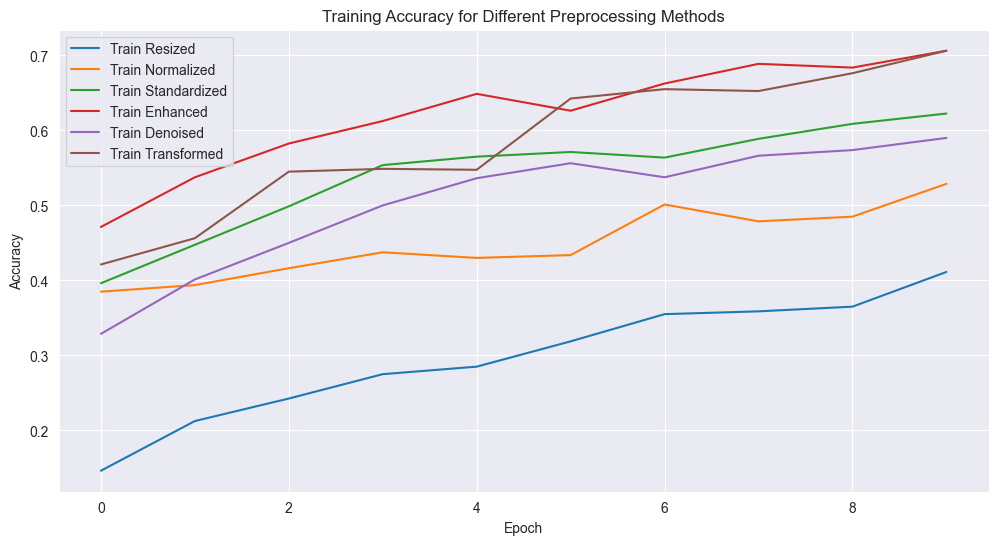

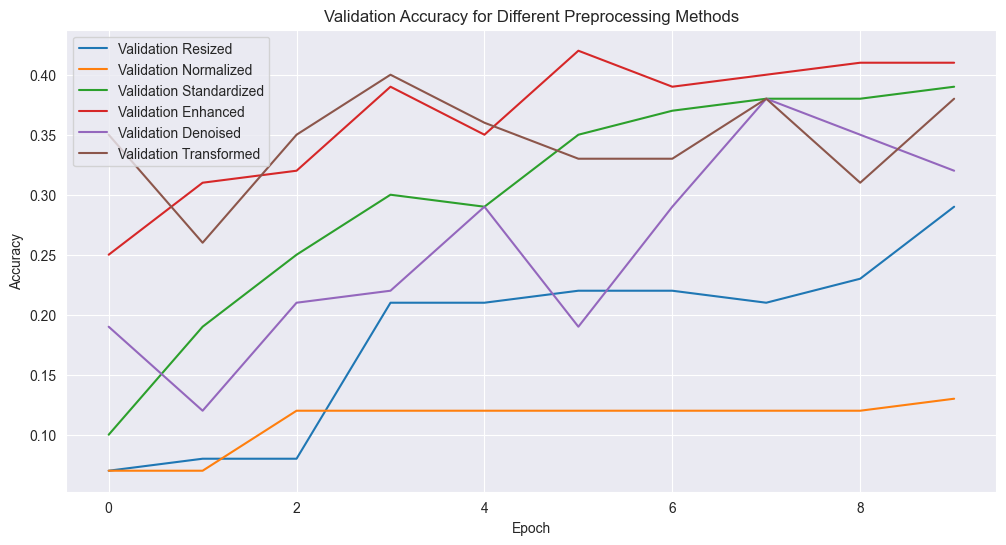

In [30]:
def plot_train_and_validation_histories(histories, labels, metric='accuracy'):
    #Training Accuracy
    plt.figure(figsize=(12, 6))
    for history, label in zip(histories, labels):
        plt.plot(history.history[metric], label=f'Train {label}')
    plt.title('Training Accuracy for Different Preprocessing Methods')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.show()

    #Validation Accuracy
    plt.figure(figsize=(12, 6))
    for history, label in zip(histories, labels):
        plt.plot(history.history[f'val_{metric}'], label=f'Validation {label}')
    plt.title('Validation Accuracy for Different Preprocessing Methods')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.show()

histories = [history_resized, history_normalized, history_standardized, history_enhanced, history_denoised, history_transformed]
labels = ['Resized', 'Normalized', 'Standardized', 'Enhanced', 'Denoised', 'Transformed']

#Plot separate graphs for train and validation accuracy
plot_train_and_validation_histories(histories, labels, metric='accuracy')


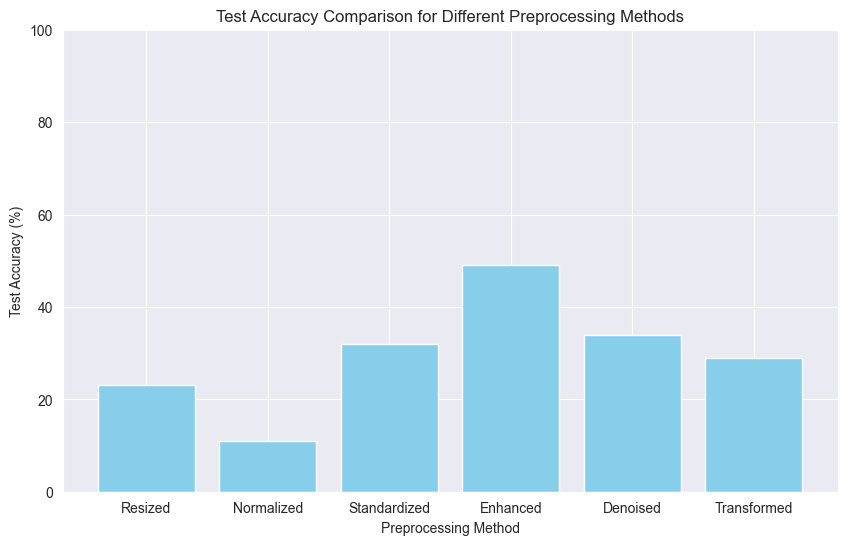

In [31]:
# Collect test accuracy for each method
accuracies = {
    'Resized': test_accuracy * 100,
    'Normalized': test_accuracy_normalized * 100,
    'Standardized': test_accuracy_standardized * 100,
    'Enhanced': test_accuracy_enhanced * 100,
    'Denoised': test_accuracy_denoised * 100,
    'Transformed': test_accuracy_transformed * 100,
}

# Plot the comparison of accuracies
plt.figure(figsize=(10, 6))
plt.bar(accuracies.keys(), accuracies.values(), color='skyblue')
plt.title('Test Accuracy Comparison for Different Preprocessing Methods')
plt.xlabel('Preprocessing Method')
plt.ylabel('Test Accuracy (%)')
plt.ylim([0, 100])
plt.show()


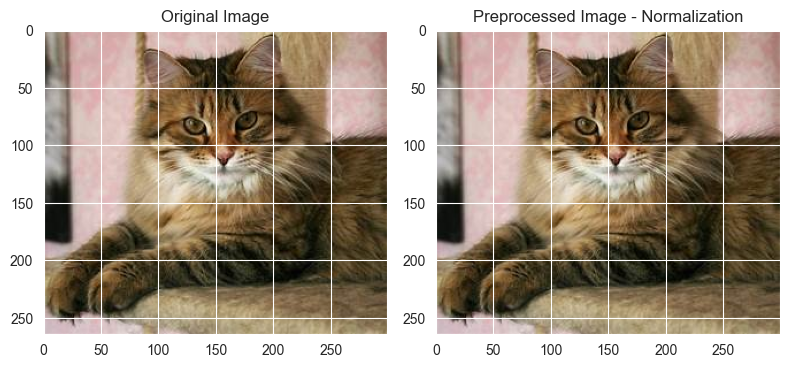

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8059072095397757..2.2328189048478375].


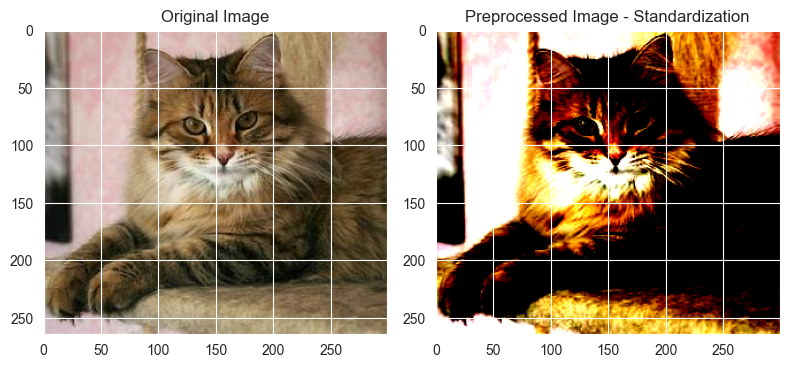

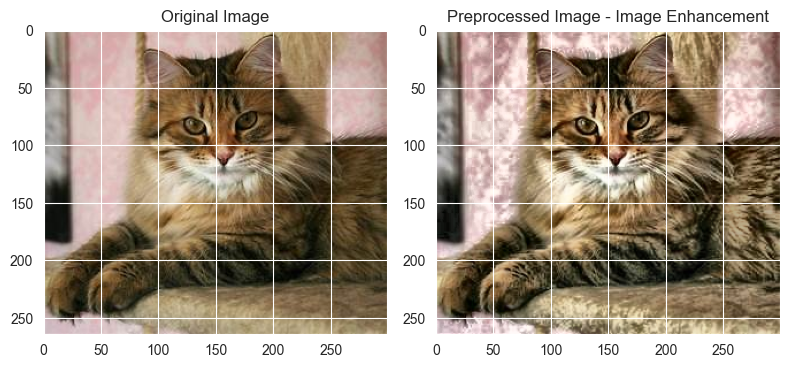

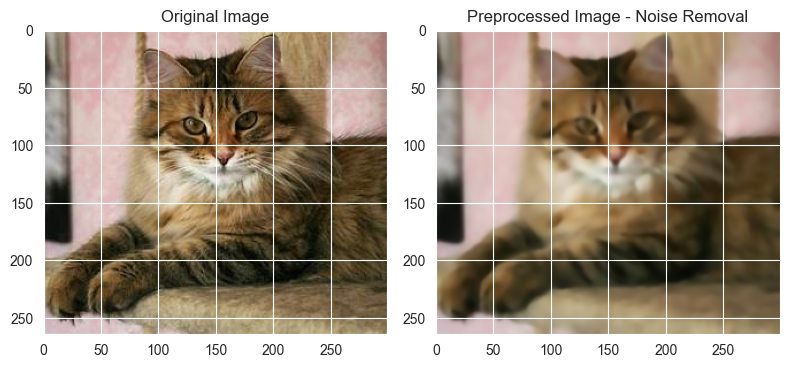

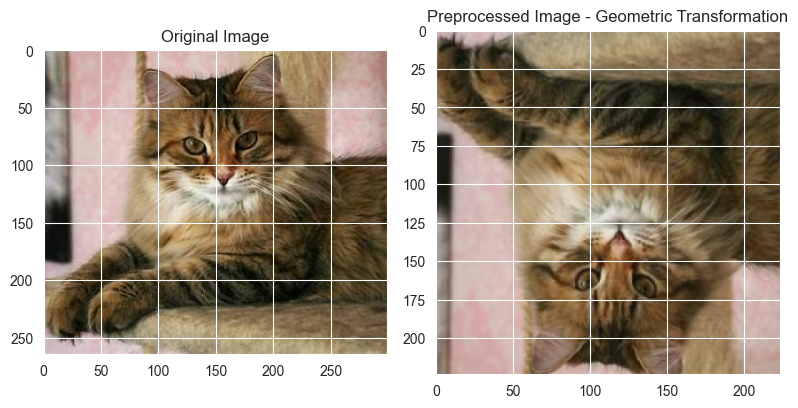

In [32]:
#Helper function to display original and preprocessed images
def visualize_preprocessing(image_path, preprocess_function, title):
    original_image = cv2.imread(image_path)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    preprocessed_image = preprocess_function(original_image)

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.title('Original Image')

    plt.subplot(1, 2, 2)
    plt.imshow(preprocessed_image)
    plt.title(f'Preprocessed Image - {title}')

    plt.tight_layout()
    plt.show()

#Example of visualizing a random image from the dataset
sample_image_path = random.choice(train_image_paths)

#Visualize for each preprocessing method
visualize_preprocessing(sample_image_path, normalize_image, 'Normalization')
visualize_preprocessing(sample_image_path, standardize_image, 'Standardization')
visualize_preprocessing(sample_image_path, enhance_image, 'Image Enhancement')
visualize_preprocessing(sample_image_path, remove_noise, 'Noise Removal')
visualize_preprocessing(sample_image_path, apply_geometric_transformation, 'Geometric Transformation')
